In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.base import BaseEstimator, TransformerMixin

try:
    import lightgbm as lgb
    LGB_AVAILABLE = True
except:
    LGB_AVAILABLE = False

import joblib
SEED = 42
np.random.seed(SEED)

print("✅ Librerías cargadas. LightGBM disponible:", LGB_AVAILABLE)

✅ Librerías cargadas. LightGBM disponible: False


In [27]:
import pandas as pd

train = pd.read_csv("TRAINING_SET_VALUES.csv", sep=",")
train_labels = pd.read_csv("TRAINING_SET_LABELS.csv", sep=",")
test = pd.read_csv("TEST_VALUES.csv", sep=",")

# Unir valores y etiquetas
train_data = train.merge(train_labels, on='id')

print(f"✅ Datos cargados:\nTrain: {train.shape}\nTest: {test.shape}")
print("\nColumnas del train:", list(train.columns[:10]))
train.head()


✅ Datos cargados:
Train: (59400, 40)
Test: (14850, 40)

Columnas del train: ['id', 'amount_tsh', 'date_recorded', 'funder', 'gps_height', 'installer', 'longitude', 'latitude', 'wpt_name', 'num_private']


,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,...,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,...,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,...,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,...,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,...,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe


In [32]:
# Limpiar posibles espacios o caracteres invisibles
train.columns = train.columns.str.strip()
train_labels.columns = train_labels.columns.str.strip()

# Confirmar que 'id' existe en ambos
assert 'id' in train.columns, "❌ 'id' no existe en train"
assert 'id' in train_labels.columns, "❌ 'id' no existe en train_labels"

# Mostrar intersección de IDs
print("🔍 IDs comunes entre train y labels:", len(set(train['id']).intersection(set(train_labels['id']))))

# Unir
train = train.merge(train_labels, on="id", how="left")

# Verificar que la columna objetivo ahora está en train
assert 'status_group' in train.columns, "❌ 'status_group' no se agregó correctamente en train"

print(f"✅ Datos cargados y unidos correctamente:\nTrain: {train.shape}\nTest: {test.shape}")
print("\nÚltimas columnas del train:", list(train.columns[-5:]))
train.head()

🔍 IDs comunes entre train y labels: 59400
✅ Datos cargados y unidos correctamente:
Train: (59400, 41)
Test: (14850, 40)

Últimas columnas del train: ['source_type', 'source_class', 'waterpoint_type', 'waterpoint_type_group', 'status_group']


,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,...,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,...,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,...,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,functional
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,...,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,non functional
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,...,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional


In [33]:
train_data.info()       # tipos de datos y valores nulos
train_data.describe()   # estadísticas generales
train_data['status_group'].value_counts()  # distribución de clases

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59400 entries, 0 to 59399
Data columns (total 41 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     59400 non-null  int64  
 1   amount_tsh             59400 non-null  float64
 2   date_recorded          59400 non-null  object 
 3   funder                 55763 non-null  object 
 4   gps_height             59400 non-null  int64  
 5   installer              55745 non-null  object 
 6   longitude              59400 non-null  float64
 7   latitude               59400 non-null  float64
 8   wpt_name               59398 non-null  object 
 9   num_private            59400 non-null  int64  
 10  basin                  59400 non-null  object 
 11  subvillage             59029 non-null  object 
 12  region                 59400 non-null  object 
 13  region_code            59400 non-null  int64  
 14  district_code          59400 non-null  int64  
 15  lg

status_group
functional                 32259
non functional             22824
functional needs repair     4317
Name: count, dtype: int64

In [34]:
print("Columnas de train_labels:")
print(train_labels.columns.tolist())

print("\nPrimeras filas:")
print(train_labels.head())

Columnas de train_labels:
['id', 'status_group']

Primeras filas:
      id    status_group
0  69572      functional
1   8776      functional
2  34310      functional
3  67743  non functional
4  19728      functional


Distribución de 'status_group':
status_group
functional                 0.543081
non functional             0.384242
functional needs repair    0.072677
Name: proportion, dtype: float64


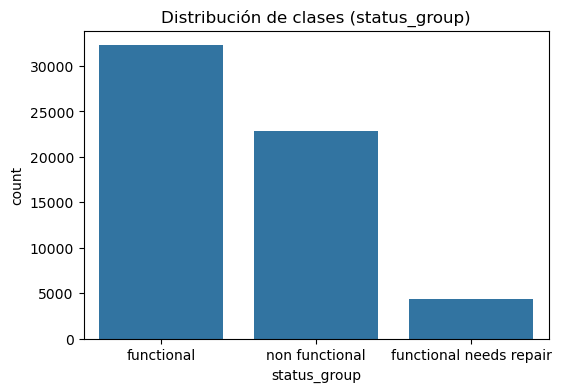


Valores nulos por columna:
scheme_name          0.485017
scheme_management    0.065286
installer            0.061532
funder               0.061229
public_meeting       0.056128
permit               0.051448
subvillage           0.006246
wpt_name             0.000034
id                   0.000000
latitude             0.000000
dtype: float64


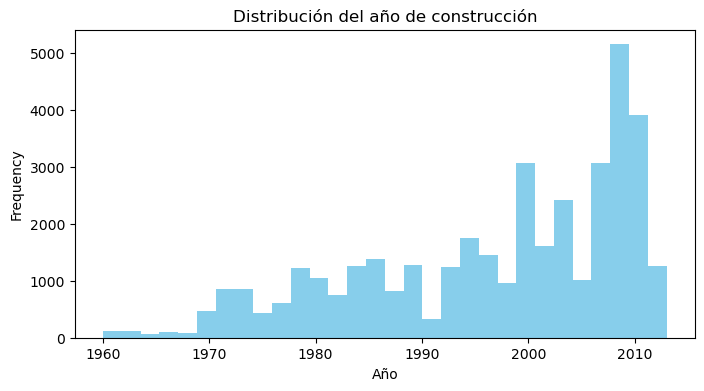

In [35]:
print("Distribución de 'status_group':")
print(train["status_group"].value_counts(normalize=True))

plt.figure(figsize=(6,4))
sns.countplot(x="status_group", data=train)
plt.title("Distribución de clases (status_group)")
plt.show()

print("\nValores nulos por columna:")
print(train.isnull().mean().sort_values(ascending=False).head(10))

if "construction_year" in train.columns:
    plt.figure(figsize=(8,4))
    train["construction_year"].replace(0, np.nan).dropna().plot(kind="hist", bins=30, color="skyblue")
    plt.title("Distribución del año de construcción")
    plt.xlabel("Año")
    plt.show()

In [38]:
train_labels.head()

,id,status_group
0,69572,functional
1,8776,functional
2,34310,functional
3,67743,non functional
4,19728,functional


In [37]:
# FEATURE ENGINEERING
class FeatureEngineer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X = X.copy()
        if 'date_recorded' in X.columns:
            dates = pd.to_datetime(X['date_recorded'], errors='coerce')
            X['recorded_year'] = dates.dt.year
            X['recorded_month'] = dates.dt.month
        
        if 'construction_year' in X.columns:
            X['construction_year'] = X['construction_year'].replace(0, np.nan)
        
        if 'recorded_year' in X.columns and 'construction_year' in X.columns:
            X['pump_age'] = X['recorded_year'] - X['construction_year']
            X.loc[(X['pump_age'] < 0) | (X['pump_age'] > 150), 'pump_age'] = np.nan
        
        cols_to_drop = [
            'wpt_name', 'num_private', 'subvillage', 
            'recorded_by', 'scheme_name', 'permit'
        ]
        X.drop(columns=[c for c in cols_to_drop if c in X.columns], inplace=True, errors='ignore')
        return X

fe = FeatureEngineer()
train_fe = fe.transform(train)
test_fe = fe.transform(test)

print("✅ Feature engineering aplicado. Train shape:", train_fe.shape)

✅ Feature engineering aplicado. Train shape: (59400, 38)


In [39]:
#  PREPROCESAMIENTO
# ==========================

TARGET = 'status_group'
ID_COL = 'id'

y = train_fe[TARGET].copy()
X = train_fe.drop(columns=[TARGET])

num_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()

if ID_COL in num_cols: num_cols.remove(ID_COL)
if ID_COL in cat_cols: cat_cols.remove(ID_COL)

print(f"Variables numéricas: {len(num_cols)}")
print(f"Variables categóricas: {len(cat_cols)}")

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

cat_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='__MISSING__')),
    ('encoder', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, num_cols),
    ('cat', cat_transformer, cat_cols)
])

Variables numéricas: 9
Variables categóricas: 25


In [43]:
# DETECTAR COLUMNAS MIXTAS
# ==============================

def detectar_columnas_mixtas(df):
    mixtas = {}
    for col in df.columns:
        tipos = df[col].dropna().map(type).unique()
        if len(tipos) > 1:
            mixtas[col] = tipos
    return mixtas

# Detectar columnas con mezcla de tipos
columnas_mixtas = detectar_columnas_mixtas(X)

if columnas_mixtas:
    print("⚠️ Columnas con tipos mezclados:")
    for col, tipos in columnas_mixtas.items():
        print(f" - {col}: {tipos}")
else:
    print("✅ No hay columnas mixtas.")

✅ No hay columnas mixtas.


In [45]:
# 🔧 LIMPIEZA DE VARIABLES CATEGÓRICAS
# ======================================

# Identificamos todas las columnas categóricas
cat_cols = X.select_dtypes(include=["object", "category", "bool"]).columns

# Convertimos TODO a string, para evitar mezcla bool/str
X[cat_cols] = X[cat_cols].astype(str)

# También aplicamos al test para evitar errores luego
test[cat_cols] = test[cat_cols].astype(str)

print(f"✅ Todas las columnas categóricas ({len(cat_cols)}) convertidas a string.")

✅ Todas las columnas categóricas (25) convertidas a string.


In [46]:
#  ENTRENAMIENTO DEL MODELO
model = RandomForestClassifier(random_state=SEED, n_jobs=-1)
param_dist = {
    'model__n_estimators': [200, 500],
    'model__max_depth': [10, 20, None]
}

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', model)
])

X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, random_state=SEED, stratify=y
)

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=SEED)
search = RandomizedSearchCV(
    pipeline,
    param_distributions=param_dist,
    n_iter=5,
    scoring='f1_macro',
    cv=cv,
    n_jobs=-1,
    verbose=2,
    random_state=SEED
)

# INSPECCIÓN DEL PREPROCESADOR
# ==============================

cat_cols = X.select_dtypes(include=["object", "category", "bool"]).columns
num_cols = X.select_dtypes(include=["int64", "float64"]).columns

print("🔢 Columnas numéricas:", len(num_cols))
print(num_cols.tolist()[:20], "..." if len(num_cols) > 20 else "")
print("\n🔤 Columnas categóricas:", len(cat_cols))
print(cat_cols.tolist()[:20], "..." if len(cat_cols) > 20 else "")

# Asegurarnos de convertir booleanas a string antes de codificar
bool_cols = X.select_dtypes(include=["bool"]).columns
if len(bool_cols) > 0:
    print(f"\n⚠️ Convertiremos {len(bool_cols)} columnas booleanas a string para evitar conflictos:")
    print(bool_cols.tolist())
    X[bool_cols] = X[bool_cols].astype(str)
else:
    print("\n✅ No hay columnas booleanas.")

print("🚀 Entrenando el modelo...")
search.fit(X_train, y_train)

print("✅ Mejor puntuación F1 macro (CV):", search.best_score_)
print("🧠 Mejores parámetros:", search.best_params_)

🔢 Columnas numéricas: 10
['id', 'amount_tsh', 'gps_height', 'longitude', 'latitude', 'region_code', 'district_code', 'population', 'construction_year', 'pump_age'] 

🔤 Columnas categóricas: 25
['date_recorded', 'funder', 'installer', 'basin', 'region', 'lga', 'ward', 'public_meeting', 'scheme_management', 'extraction_type', 'extraction_type_group', 'extraction_type_class', 'management', 'management_group', 'payment', 'payment_type', 'water_quality', 'quality_group', 'quantity', 'quantity_group'] ...

✅ No hay columnas booleanas.
🚀 Entrenando el modelo...
Fitting 3 folds for each of 5 candidates, totalling 15 fits
✅ Mejor puntuación F1 macro (CV): 0.6852000214158606
🧠 Mejores parámetros: {'model__n_estimators': 500, 'model__max_depth': None}


🔎 Reporte de clasificación:
                         precision    recall  f1-score   support

             functional       0.81      0.89      0.85      6452
functional needs repair       0.53      0.34      0.42       863
         non functional       0.84      0.79      0.81      4565

               accuracy                           0.81     11880
              macro avg       0.73      0.67      0.69     11880
           weighted avg       0.80      0.81      0.80     11880



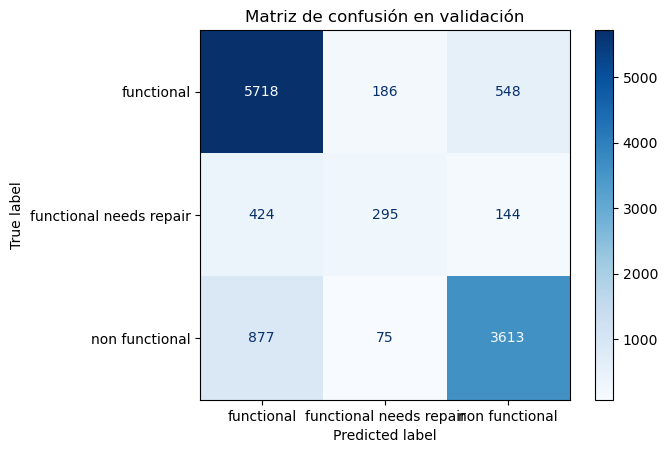

💾 Modelo guardado en best_model_pipeline.joblib


In [47]:
#  EVALUACIÓN DEL MODELO
# ==========================

best_model = search.best_estimator_
y_pred = best_model.predict(X_valid)

print("🔎 Reporte de clasificación:")
print(classification_report(y_valid, y_pred))

cm = confusion_matrix(y_valid, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_valid))
disp.plot(cmap="Blues", values_format='d')
plt.title("Matriz de confusión en validación")
plt.show()

joblib.dump(best_model, "best_model_pipeline.joblib")
print("💾 Modelo guardado en best_model_pipeline.joblib")

🔮 Preprocesando el conjunto de test...
📈 Generando predicciones...


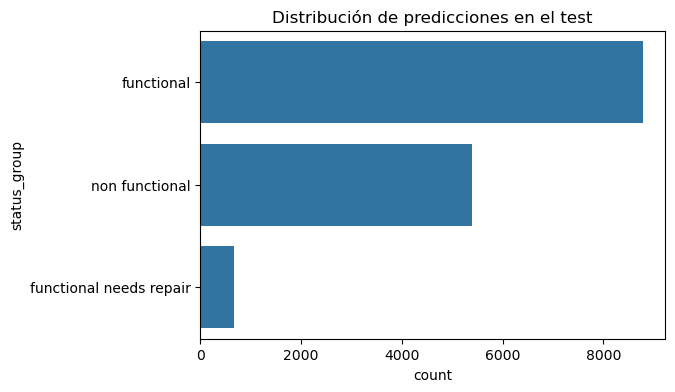

✅ Archivo submission.csv creado con 14850 filas


,id,status_group
0,50785,non functional
1,51630,functional
2,17168,functional
3,45559,non functional
4,49871,functional


In [48]:
#  PREDICCIÓN EN TEST
# ==========================

print("🔮 Preprocesando el conjunto de test...")
X_test = test_fe.copy()
for c in X.columns:
    if c not in X_test.columns:
        X_test[c] = np.nan
X_test = X_test[X.columns]

print("📈 Generando predicciones...")
y_test_pred = best_model.predict(X_test)

# Mostrar distribución de predicciones
pred_df = pd.DataFrame({"status_group": y_test_pred})
plt.figure(figsize=(6,4))
sns.countplot(y="status_group", data=pred_df, order=pred_df["status_group"].value_counts().index)
plt.title("Distribución de predicciones en el test")
plt.show()

# Crear submission
submission = pd.DataFrame({
    'id': test[ID_COL],
    'status_group': y_test_pred
})
submission.to_csv("submission.csv", index=False)
print("✅ Archivo submission.csv creado con", len(submission), "filas")
submission.head()